 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/ipython-notebooks/research/NetworkX%20Lattices/Lattices%20With%20NetworkX%20-%20Part%203%2C%20Classes%20with%20QuTiP.ipynb#Classes-with-QuTiP" data-toc-modified-id="Classes-with-QuTiP-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Classes with QuTiP</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/ipython-notebooks/research/NetworkX%20Lattices/Lattices%20With%20NetworkX%20-%20Part%203%2C%20Classes%20with%20QuTiP.ipynb#switch-Class-Definition" data-toc-modified-id="switch-Class-Definition-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><code>switch</code> Class Definition</a></span></li><li><span><a href="http://localhost:8888/notebooks/ipython-notebooks/research/NetworkX%20Lattices/Lattices%20With%20NetworkX%20-%20Part%203%2C%20Classes%20with%20QuTiP.ipynb#SquareLattice-Class-Definition" data-toc-modified-id="SquareLattice-Class-Definition-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><code>SquareLattice</code> Class Definition</a></span></li><li><span><a href="http://localhost:8888/notebooks/ipython-notebooks/research/NetworkX%20Lattices/Lattices%20With%20NetworkX%20-%20Part%203%2C%20Classes%20with%20QuTiP.ipynb#qutipHamiltonian-Class-Definition" data-toc-modified-id="qutipHamiltonian-Class-Definition-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span><code>qutipHamiltonian</code> Class Definition</a></span></li></ul></li></ul></div>

# Classes with QuTiP

In [1]:
import networkx as nx
import numpy as np
import matplotlib as matplotlib
matplotlib.use('qt4agg')
import matplotlib.pyplot as plt
import random

from qutip import *

In [2]:
%matplotlib inline

## `switch` Class Definition

Reference: [ActiveState Recipes](http://code.activestate.com/recipes/410692/)

Example Usage:

The following example is pretty much the exact use-case of a dictionary, but is included for its simplicity. Note that you can include statements in each suite.
    
```
v = 'ten'
for case in switch(v):
    if case('one'):
        print 1
        break
    if case('two'):
        print 2
        break
    if case('ten'):
        print 10
        break
    if case('eleven'):
        print 11
        break
    if case(): # default, could also just omit condition or 'if True'
        print "something else!"
        # No need to break here, it'll stop anyway
```

In [3]:
# This class provides the functionality we want. You only need to look at
# this if you want to know how this works. It only needs to be defined
# once, no need to muck around with its internals.
class switch(object):
    def __init__(self, value):
        self.value = value
        self.fall = False

    def __iter__(self):
        """Return the match method once, then stop"""
        yield self.match
        raise StopIteration
    
    def match(self, *args):
        """Indicate whether or not to enter a case suite"""
        if self.fall or not args:
            return True
        elif self.value in args: # changed for v1.5, see below
            self.fall = True
            return True
        else:
            return False

## `SquareLattice` Class Definition

In [4]:
from qutip import *

In [5]:
class hashQobj(Qobj):
    
    def __hash__(self):
        return hash(repr(self))

In [6]:
class qutipSquareLattice():
    
    hamiltonian = None
    
    hamOp = Qobj()
    
    graph = nx.empty_graph(0)
    size = 0
    dims = 2
    state = np.empty([]) # create empty array
    colors = ['r','b','g','c','m','y','k','w']
    color_map = {}
#     upspin = hashQobj(basis(2,0))
#     dnspin = hashQobj(basis(2,1))
#     color_map = {upspin:'r', dnspin :'b'}
    state_values = []
    node_color_dict = {} # dictionary whose keys are nodes and values are colors for each node
    node_colors = []
    pos_dict = {}
    
    use_default_vars = True
    
    scale_mult = 0
    
    def __init__(self,size=10,periodic=False,hamType=None,hamVars=None):
        self.size = size
        self.graph = nx.grid_2d_graph(size,size,periodic=periodic)
        
        self.scale_mult = 10.0/self.size
        
        for node in self.graph:
            self.pos_dict[node] = [self.scale_mult*node[0],self.scale_mult*node[1]] # set the node co-ordinates to be same as node indices
        
        if hamType:
            self.hamiltonian = qutipHamiltonian(hamType,self.graph,hamVars)
            self.hamOp = self.hamiltonian.hamOp
            self.dims = self.hamiltonian.dims
            self.state_values = [hashQobj(basis(self.dims,i)) for i in range(self.dims)] # Possible states of a given site
            print(self.state_values)
            for i in range(self.dims):
                self.color_map[self.state_values[i]] = self.colors[i]
            self.setRandomState()
    
    def setRandomState(self):
        '''Iterates over all nodes in the graph. For each node, creates an attribute
        labeled 'state', and assigns to it at random QuTiP objects returned by basis(2,0) or basis(2,1)
        corresponding to spin up or spin down.'''

        for node in self.graph:
            self.graph.node[node]['state'] = self.state_values[np.random.randint(self.dims)]
            self.node_color_dict[node] = self.color_map[self.graph.node[node]['state']]

        self.node_colors = list(self.node_color_dict.values())
        
        return

    
    def nearestEnergy(self,node):
        energy = 0.
        for neighbor in self.graph[node]:
            tempstate = tensor(self.graph.node[node]['state'],self.graph.node[neighbor]['state'])
            energy += expect(self.hamOp,tempstate)
        return energy
    
    def nextNearestEnergy(self,node):
        energy = 0.
        for nearest in self.graph[node]:
            for nextnearest in self.graph[nearest]:
                if nextnearest!=node:
                    tempstate = tensor(self.graph.node[node]['state'],self.graph.node[nextnearest]['state'])
                    energy += expect(self.hamOp,tempstate)
        return energy
    
    def latticeEnergy(self):
        energy = 0
        for node in self.graph:
            energy = energy + self.nearestEnergy(node)
        return energy
    
    def draw(self):
        nx.draw(self.graph,pos=self.pos_dict,node_color=self.node_colors,node_size=50*self.scale_mult)
                

## `qutipHamiltonian` Class Definition

In [7]:
class qutipHamiltonian():
    '''Class which defines the hamiltonian acting on a given site of a lattice'''
    
    hamTypes = ['NumberOp', 'Ising', 'Heisenberg','Hubbard', 'AKLT', 'SpinGlass']
    
    defaultVars = {'NumberOp':   {'J':1, 'dims': 2},
                   'Ising':      {'J': 1, 'mu': 0, 'extfield': 0},
                   'Heisenberg': {'J': 1, 'mu': 0, 'extfield': 0, 'dims': 3},
                   'Hubbard':    {'J': 1, 'U': 0, 'mu': 1, 'extfield': 0},
                   'SpinGlass':  {'J_ij': [[]], 'mu': 0, 'extfield': 0 },
                   'AKLT':       {'J': 1}
              }             # default values of Hamiltonian parameters
    
    hamType = None          # type of Hamiltonian: Ising, Heisenberg, Hubbard etc.
    
    hamOp = Qobj()          # single-site Hamiltonian operator
    
    hamVars = {}            # parameters necessary for defining Hamiltonian, coupling strengths, etc.
    
    graph = None            # graph on which Hamiltonian is defined.
    
    dims = 2                # dimension of single particle Hilbert space.
    
    latticeDimension = 2    # dimension of lattice on which Hamiltonian is defined.

    latticeSize = (5,5)     # tuple containing number of sites in lattice, should match latticeDimension.
    
    def __init__(self, hamType, graph=None, hamVars=None):
#         try:
#             from qutip import *
#         except:
#             raise NameError('QuTiP is not installed')
        
        if hamType != None:
            if hamType not in self.hamTypes:
#                 from string import join
                raise ValueError('hamType must be one of ',self.hamTypes)
            else:
                self.hamType = hamType
                self.initHamiltonian(graph,hamType,hamVars)
                
    def initHamiltonian(self,graph,hamType,hamVars):
        
#         self.hamFunc = getattr(self,'hamiltonian'+hamType)
        if graph!=None:
            self.graph = graph
        else:
            print('Lattice is not defined.')
        
        defVars = self.defaultVars.get(hamType)
        
        print(defVars)
        
        if hamVars:
            if set(hamVars.keys()).issubset(set(self.defVars.keys())):
                self.setHamiltonianVars(hamType,hamVars)
                self.setHamiltonianOp(hamType)
            else:
                raise ValueError('Hamiltonian variables for', self.hamType, 'model, should subset of:'\
                                            ,defVars)
        else:
            print('Hamiltonian parameters not specified. Using default values')
            self.setHamiltonianVars(hamType,defVars)
            self.setHamiltonianOp(hamType)
            
        return
    
    def setHamiltonianVars(self,hamType,hamVars):

#         if hamVars==None:
#             raise ValueError('Hamiltonian parameters not specified. Exiting')
#         if hamType==None:
#             raise ValueError('Hamiltonian type not specified. Exiting')
        self.hamVars = self.defaultVars.get(hamType)
        for k in hamVars.keys():
            self.hamVars[k] = hamVars[k]    

        for case in switch(hamType):
            if case('Ising'):
                print('Ising')
                self.J = self.hamVars['J']
                self.mu = self.hamVars['mu']
                self.h = self.hamVars['extfield']
                break

            if case('Hubbard'):
                print('Hubbard')
                self.J = self.hamVars['J']
                self.mu = self.hamVars['mu']
                self.h = self.hamVars['extfield']
                self.U = self.hamVars['U']
                break
                
            if case('Heisenberg'):
                print('Heisenberg')
                self.J = self.hamVars['J']
                self.h = self.hamVars['extfield']
                self.mu = self.hamVars['mu']
                self.dims = 3     # Heisenberg spin-chain has spin 1 particles
                break
            
            if case('AKLT'):
                print('AKLT')
                self.J = self.hamVars['J']
                
#             if case('SpinGlass'):
#                 if hamVars:
#                     self.J_ij = hamVars['J_ij']
#                     self.h = hamVars['extfield']
#                     self.mu = hamVars['mu']
#                 else:
#                     self.J = 1
#                     self.h = 0
#                     self.mu = 0
#                 break
                
            if case('NumberOp'):
                break
            
            return
                
    def setHamiltonianOp(self,hamType):
        if self.hamVars.get('dims'):
            self.dims = self.hamVars['dims']
        else:
            self.dims = 2

        dim = self.dims
        j = (dim-1)/2.0
        
        sx = jmat(j,'x')
        sy = jmat(j,'y')
        sz = jmat(j,'z')
        sp = jmat(j,'+')
        sm = jmat(j,'-')
        identity = qeye(dim)
        
        
        for case in switch(hamType):
            if case('Ising'):
                self.hamOp = -self.J * tensor(sz,sz) \
                                            - self.mu * self.h * tensor(sz,identity)
                break
            
            if case('AKLT'):
                self.hamOp = self.J * (tensor(sx,sx) + tensor(sy,sy) + tensor(sz,sz))
                self.hamOp += self.J/3.0 * (tensor(sx,sx) + tensor(sy,sy) + tensor(sz,sz))**2
            
            if case('Hubbard'):
                break
                
            if case('Heisenberg'):
                self.hamOp = -0.5*self.J * (tensor(sp,sm) + tensor(sm,sp))
                self.hamOp += -self.J * tensor(sz,sz)
                break
                
#             if case('SpinGlass'):
#                 if hamVars:
#                     self.J_ij = hamVars['J_ij']
#                     self.h = hamVars['extfield']
#                     self.mu = hamVars['mu']
#                 else:
#                     self.J = 1
#                     self.h = 0
#                     self.mu = 0
#                 break
                
            if case('NumberOp'):
                break        
            
            return
    
    @property
    def hermitian(self):
        return self._isHermitian
    
    @hermitian.setter
    def hermitian(self, value):
        if isinstance(value, bool):
            self._isHermitian = value
        else:
            raise ValueError('hermitian must be a boolean data type')

In [56]:
jmat(0.5,'z')

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]]

In [90]:
latt = qutipSquareLattice(size=5,hamType='AKLT')

{'J': 1}
Hamiltonian parameters not specified. Using default values
AKLT
[Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
Qobj data =
[[ 1.]
 [ 0.]], Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
Qobj data =
[[ 0.]
 [ 1.]]]


In [91]:
latt.hamiltonian.hamOp

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.27083333  0.          0.          0.        ]
 [ 0.         -0.14583333  0.41666667  0.        ]
 [ 0.          0.41666667 -0.14583333  0.        ]
 [ 0.          0.          0.          0.27083333]]

In [92]:
latt.setRandomState()

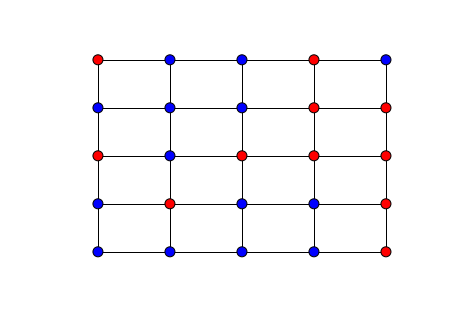

In [93]:
latt.draw()

In [94]:
latt.latticeEnergy()

8.33333333333333

In [95]:
energies = []
for i in range(500):
    latt.setRandomState()
    energies.append(latt.latticeEnergy())

(array([  1.,   2.,   5.,  11.,  13.,  21.,  41.,  62.,  54.,  64.,  64.,
         47.,  43.,  33.,  15.,   8.,   7.,   6.,   1.,   2.]),
 array([ -2.5       ,  -1.70833333,  -0.91666667,  -0.125     ,
          0.66666667,   1.45833333,   2.25      ,   3.04166667,
          3.83333333,   4.625     ,   5.41666667,   6.20833333,
          7.        ,   7.79166667,   8.58333333,   9.375     ,
         10.16666667,  10.95833333,  11.75      ,  12.54166667,  13.33333333]),
 <a list of 20 Patch objects>)

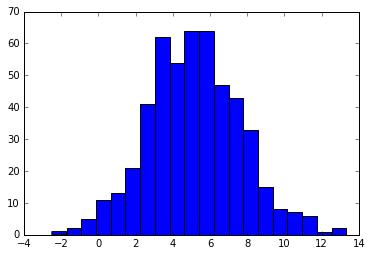

In [98]:
plt.hist(energies,bins=20)

In [ ]:
set.issubset?

In [ ]:
create?

In [ ]:
x = hashQobj

In [ ]:
hash(x)

In [ ]:
x = hashQobj(basis(2,0))

In [ ]:
hash(x)

In [ ]:
x

In [ ]:
x = {}

In [ ]:
len(x)

In [ ]:
basis(3,2)

In [ ]:
basis(2,1)

In [ ]:
np.ndarray?

In [ ]:
size = 4
arr = np.ndarray([size,size],dtype=Qobj)
arr

In [ ]:
type(arr[0][1])

In [ ]:
latt = SquareLattice(size=50,periodic=True,hamiltonian='SpinGlass',ham_vars={'mu': 0, 'extfield': 0, 'J_ij': 1})

In [ ]:
latt.setRandomState()

print(latt.latticeEnergy())

latt.draw()

In [ ]:
energies = []
for i in range(500):
    latt.setRandomState()
    energies.append(latt.latticeEnergy())

In [ ]:
plt.hist(energies,bins=40)

In [ ]:
energy_set = set(energies)
for e in sorted(energy_set):
    print(e,'\t',energies.count(e))

In [ ]:
print?

In [ ]:
latt.hamiltonianVars

In [ ]:
x = {'i':1,'j':2}
x

In [ ]:
x.values()

In [ ]:
x.get?

In [ ]:
x.get('k')

In [ ]:
set(x.keys())

In [ ]:
y = {'j':1,'i':2}
y

In [ ]:
set(x.keys()) ^ set(y.keys())

In [ ]:
x.keys() == y.keys()

In [ ]:
nx.grid_2d_graph?

In [ ]:
# Dead code

#     def hamiltonianIsing(self,node):
#         energy = 0.
#         for neighbor in self.graph[node]:
#             tempstate = tensor(self.graph.node[node]['state'],self.graph.node[neighbor]['state'])
#             energy += expect(self.hamOp)
# #             energy += -self.J*self.graph.node[node]['state']*self.graph.node[neighbor]['state']
# #             energy += -self.mu*self.h*self.graph.node[node]['state']
#         return energy
    
# #     def hamiltonianSpinGlass(self,node):
# #         energy = 0.
# #         for neighbor in self.graph[node]:
# #             energy += 0
    
#     def hamiltonianHubbard(self,node):
#         energy = 0.
# #         for neighbor in self.graph[node]:
# #             energy += -self.J*
#         return 0
    
#     def hamiltonianHeisenberg(self,node):
#         energy = 0.
#         for neighbor in graph[node]:
#             energy += -self.J*self.graph.node[node]['state']*self.graph.node[neighbor]['state']
#             energy += -self.mu*self.h*self.graph.node[node]['state']
#         return 0
    
#     def hamiltonianNumberOp(self,node):
#         return 0
    